Preliminaries
==============

Mount your GDrive using the file browser OR run the code below:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Corpus Analytics
==============

Now that we've overviewed all the steps involved in preparing text for computational analysis, we can begin the 
work of analysis proper. Whereas the last chapter suggested a few ways we might do this with a single novel, this 
one will build out to a whole collection of texts, or a **corpus**. Computational analysis can help us discover 
many interesting things about a single text, but looking at this text in the context of many others will do much to 
clarify and expand any potential findings we might make. Accordingly, we'll learn how to implement our cleaning 
steps on multiple files and then format them in a way that enables us to make connections between them. We'll then 
generate several metrics about these texts and use them to observe similarities/differences across the corpus.

We'll also leave _Frankenstein_ behind. In place of this novel, we will use Melanie Walsh's [collection] of ~380 
obituaries from the _New York Times_.  "Obituary subjects," Walsh writes, "include academics, military generals, 
artists, athletes, activists, politicians, and businesspeople — such as Ada Lovelace, Ulysses Grant, Marilyn 
Monroe, Virginia Woolf, Jackie Robinson, Marsha P. Johnson, Cesar Chavez, John F. Kennedy, Ray Kroc, and many more."

[collection]: https://melaniewalsh.github.io/Intro-Cultural-Analytics/00-Datasets/00-Datasets.html

```{admonition} Learning Objectives
By the end of this chapter, you will be able to:

+ Develop a workflow for cleaning multiple texts and compiling them into a corpus
+ Use a document-term matrix, to represent relationships between texts in a corpus
+ Generate metrics about texts in a corpus, including document length, term frequency, lexical diversity, etc.
+ Explain the difference between raw term metrics and weighted term scoring (specifically, tf-idf scoring)
```

Using a File Manifest
-------------------------

Before we begin cleaning, let's load in a file manifest to get a quick overview of what will be in our corpus. 
We'll also use this manifest to sequentially load each file, clean it, and add it to our corpus.

In [ ]:
import pandas as pd

manifest = pd.read_csv("/content/drive/MyDrive/rbs_digital_approaches_2022/2022_data_class/tm_2/manifest.csv", index_col = 0)
manifest = manifest.assign(YEAR = pd.to_datetime(manifest['YEAR'], format = "%Y").dt.year)

print(
    "Number of obituaries:", len(manifest),
    "\nNumber of different people:", manifest['NAME'].nunique(),
    "\nColumns in the manifest:", manifest.columns.values
)

date_range = range(manifest['YEAR'].min(), manifest['YEAR'].max()+5, 5)
manifest.groupby('YEAR')['NAME'].count().plot(
    figsize = (15, 5),
    title = 'Number of Obituaries per Year',
    xlabel = 'Year',
    ylabel = 'Count',
    xticks = date_range,
    yticks = range(0, 15),
    rot = 45
);

Here are a few people in the corpus, selected at random:

In [ ]:
for idx in manifest.sample(5).index:
    print(f"Name: {manifest.loc[idx, 'NAME']}\nYear: {manifest.loc[idx, 'YEAR']}\n")

```{tip}
Using a metadata sheet like this is a good habit to develop. Use it as a common reference point for any processes 
you run on your data, and you'll mitigate major headaches stemming from undocumented projects. For more about this, 
see the DataLab's [workshop on project organization and data documentation][].

[workshop on project organization and data documentation]: https://ucdavisdatalab.github.io/workshop_how-to-data-documentation/
```

Text Cleaning
----------------

### Recap

With our manifest loaded, we can review our cleaning steps. For each text in our corpus, we want to:

1. Resolve casing
2. Remove punctuation, numbers, and any extra formatting
3. Remove stop words

This should feel familiar, though our workflow here will differ slightly from the one in the last chapter because 
we'll be cleaning multiple texts, not only one. All the principles remain the same, we just want to implement our 
cleaning steps in a way that successively works through every text in our data directory without much intervention 
on our part. This is where functions are helpful; we'll define a series of them, with each performing a separate 
step in the cleaning process. We'll also define a main function, `clean()`, which we'll use to control the various 
cleaning steps. That way we can simply load in a text file and pass it to `clean()` and `clean()` will handle the 
rest.

Note that our steps do not include lemmatizing the texts. Because lemmatization can be labor- and time-intensive, 
**these texts have already been processed with `nltk`'s lemmatizer**.

### Text cleaning functions

`clean()` will call the following five functions:

1. `to_lower()`: returns a lowercase version of all tokens in a text
2. `remove_punctuation()`: removes all punctuation in phases: hyphens, em dashes, and underscores first, then 
everything else
3. `remove_digits()`: removes digits
4. `remove_whitespace()`: removes any extra whitespace
5. `remove_stop_words()`: filters out stop words from the list of tokens; we'll also remove any words that are two 
or less characters long

Let's get coding!

In [7]:
import re

with open("/content/drive/MyDrive/rbs_digital_approaches_2022/2022_data_class/voyant_stoplist.txt", 'r') as f:
    stopwords = f.read().split("\n")

def to_lower(doc):
    return doc.lower()

def remove_punctuation(doc):
    doc = re.sub(r"[-]|[—]|[_]", " ", doc)
    doc = re.sub(r"[^\w\s]", "", doc)
    return doc

def remove_digits(doc):
    return re.sub(r"[0-9]", "", doc)

def remove_whitespace(doc):
    return re.sub(r"\s+", " ", doc)

def remove_stop_words(doc):
    doc = doc.split()
    doc = [token for token in doc if token not in stopwords]
    doc = [token for token in doc if len(token) > 2]
    doc = ' '.join(doc)
    return doc

def clean(doc):
    lowercase = to_lower(doc)
    no_punct = remove_punctuation(lowercase)
    no_digits = remove_digits(no_punct)
    no_whitespace = remove_whitespace(no_digits)
    stopped = remove_stop_words(no_whitespace)
    return stopped

```{admonition} About the above...
These functions are written with **clarity** and **modularity** in mind. The intent here is to demonstrate each 
step of the cleaning process in as discrete a manner as possible. But you might find that some of this code is 
redundant (as an example, ask yourself: which step might be wrapped up inside another function?). Further, we could 
very probably re-factor this code to optimize it, which would be important when working with a large number of 
texts. We won't cover something like that in this session, however. For now, know that these functions are meant to 
act as templates, which you can modify to suit your own needs.
```

### Cleaning our texts

With our functions defined, we can now load each text, roll through all the cleaning steps, and append the cleaned 
text to a list. The result will be our **corpus**, a list of strings, where each string contains all the tokens in 
a given text. The _order_ of these entries will be important for work we want to do later on, so we need to make 
sure that each string always has the same position in the larger list of texts. This is where the file manifest 
comes in: _we'll load texts in the order provided by the `FILE_NAME` column of `manifest`_. Doing so ensures that 
the first index (`0`) of our corpus corresponds to the first text, the second index (`1`) to the second, and so on.


Let's write all this out in a `for` loop and do our cleaning.

```{margin} What this loop does:
1. For every row (`idx`) in `manifest`, collect the item in the row's `FILE_NAME` column and append it to `indir`
2. Put the resultant filepath in a `with...open` statement to read in a file
3. Clean the story with `clean()`
4. Append the result to `corpus`
```

In [8]:
indir =  "/content/drive/MyDrive/rbs_digital_approaches_2022/2022_data_class/tm_2/input/"
corpus = []

for title in manifest.index:
    filepath = indir + manifest.loc[title, 'FILE_NAME']
    with open(filepath, 'r') as f:
        text = f.read()
        cleaned = clean(text)
        corpus.append(cleaned)

As a sanity check, we can run an assertion statement, which checks that `corpus` has as many texts in it as 
`manifest` does...

```{margin} On assertions...
If the lengths of `corpus` and `manifest` didn't match, `assert` would throw an `AssertionError` with the message 
after the comma.
```

In [9]:
assert len(corpus) == len(manifest), "Lengths don't match!"

...and we can inspect some tokens from a few texts to make sure all is well:

In [ ]:
for idx in manifest.sample(3).index:
    fragment = corpus[idx].split()
    print(' '.join(fragment[10:20]))

Looks great!

The Document-Term Matrix
--------------------------------

Before we switch into full data exploration mode, we're going to perform one last formatting process on our corpus. 
Remember from the last chapter that much of text analytics relies on **counts** and **context**: tracking the 
former in tandem with the latter is how we identify relationships between words (the final section on bigram PMI 
scores demonstrated this, for example). As with _Frankenstein_, here we'll want to tally up all the words in each 
text. That produces one kind of context – or rather, fifty different contexts: one for every file we've loaded and 
cleaned. But we have at our hands a corpus, the analysis of which requires a different kind of context: a single 
one for all the texts. That is, we need a way to relate texts _to each other_, instead of only tracking word values 
inside a single text.

To do so, we'll build a **document-term matrix**, or **DTM**. A DTM is a matrix that contains the frequencies of 
_all_ terms in a corpus. Every row in this matrix corresponds to a text, while every column corresponds to a term. 
For a given text, we count the number of times that term appears and enter that number in the column in question. 
We do this _even if_ the count is zero; key to the way a DTM works is that it represents corpus-wide relationships 
between texts, so it matters if a text does or doesn't contain a term.

Here's a toy example. Imagine three documents:

1. "I like cats. Do you?"
2. "I only like dogs. And you?"
3. "I like cats and dogs."

Transforming these into a document-term matrix would yield:

In [ ]:
example_corpus = [[1, 0, 1, 1, 0, 0, 1, 1],
                  [1, 1, 1, 0, 1, 1, 0, 1],
                  [1, 0, 1, 1, 1, 1, 0, 0]]

example_dtm = pd.DataFrame(
    example_corpus, 
    index = ['D1', 'D2', 'D3'], 
    columns = ['i', 'only', 'like', 'cats', 'and', 'dogs', 'do', 'you']
)

example_dtm

Representing texts in this way is incredibly useful because it enables us to easily (and programmatically) discern 
similarities and differences in our corpus. For example, we can see that each of the above documents contains the 
words "i" and "like." Given that, if we wanted to know what makes each document unique, we could ignore those two 
words and focus on the rest of the values.

Now, imagine doing this for thousands of words. What patterns might emerge?

The `scikit-learn` library makes generating a DTM very easy. All we need to do is import a `CountVectorizer()` 
object, initialize it by assigning it to a variable, and fit it to our corpus. This will result in two things: 1) a 
fitted `CountVectorizer()`, which will contain a series of different attributes that are useful for corpus 
exploration; 2) a vectorized representation of our corpus, the document-term matrix.

```{margin} More on this
`CountVectorizer()` accepts several different arguments that will modify its base functionality, including 
arguments for applying some text cleaning steps. We won't use any of these arguments because we've already cleaned 
our text (and indeed it's a good idea to clean your text yourself so you always know what processes have been run 
on it), but you can learn more about them [here].

[here]: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
```

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
vectorized_corpus = count_vectorizer.fit_transform(corpus)

print(
    f"Shape of our document-term matrix: {vectorized_corpus.shape},", 
    f"or {vectorized_corpus.shape[0]} documents (rows)", 
    f"and {vectorized_corpus.shape[1]} words (columns)"
)

`CountVectorizer()` returns a **sparse matrix**, or a matrix comprised mostly of zeros. This matrix has been 
formatted to be highly memory efficient, which is useful when dealing with giant datasets, but it's not very 
accessible for data exploration. Since our corpus is relatively small, we'll convert this sparse matrix into a 
`Pandas` dataframe. Note all the zeros!

In [ ]:
dtm = pd.DataFrame(vectorized_corpus.toarray())
dtm.iloc[:5, 100:115]

As it stands, this dataframe is hard to understand. But luckily, we've kept track of which row corresponds to which 
text: this is why we used our manifest to control our file order. Further, the fitted `CountVectorizer()` has a 
special method, `get_feature_names_out()`, which will generate an array of all the tokens from all the files (our 
vocabulary). The order of this array corresponds to the order of our columns. Accordingly, we can assign this array 
to the column names of `dtm` and assign the people's names in `manifest` to its index, making it much easier to 
associate column values with row values.

In [ ]:
dtm.columns = count_vectorizer.get_feature_names_out()
dtm.index = manifest['NAME']
dtm.iloc[:5,:15]

Analyzing the Corpus
-------------------------

With our DTM made, we can use it to generate some metrics about each text in our corpus. We'll use `Pandas` data 
manipulations in conjunction with `NumPy` to do this.

### Raw Metrics: Documents

Here's an easy one: let's count the number of tokens in each text and assign the result to a new column in our 
manifest.

```{margin} Vectorized functions
If you're unfamiliar with `apply()`, or it's just been a while since you've used it, this method applies a function 
along an axis of a dataframe. Think of it like a shorthand for a `for` loop: the default usage runs every column 
through your desired function. In this case, we're setting the `axis` to `1` so `sum()` runs on every row. This 
will sum together each value in every row.
```

```{margin} Sampling ticks
Here, we're using `[::N]` to sample every `N` rows. This only grabs the raw index numbers though, so we have to 
align those numbers with their associated names after the fact with `ax.set_xticklabels()`.
```

In [ ]:
import numpy as np

manifest = manifest.assign(NUM_TOKENS = dtm.apply(sum, axis = 1).values)

to_plot = manifest.sort_values('NUM_TOKENS', ascending = False).reset_index(drop=True)
ax = to_plot.plot.bar(
    figsize = (15, 5),
    y = 'NUM_TOKENS', 
    title = 'Tokens per Text',
    xlabel = 'Name',
    ylabel = 'Number of Tokens',
    legend = False,
    xticks = to_plot[::15].index,
)
ax.set_xticklabels(to_plot[::15]['NAME']);

We can also count the number of unique words, or **types**, in each text. Types correspond to a text's vocabulary, 
whereas tokens correspond to the amount of each of those types.

In [ ]:
manifest = manifest.assign(NUM_TYPES = dtm.apply(np.count_nonzero, axis = 1).values)

to_plot = manifest.sort_values('NUM_TYPES', ascending = False).reset_index(drop=True)
ax = to_plot.plot.bar(
    figsize = (15, 5),
    y = 'NUM_TYPES', 
    title = 'Types per Text',
    xlabel = 'Name',
    ylabel = 'Number of Types',
    legend = False,
    xticks = to_plot[::15].index,
)
ax.set_xticklabels(to_plot[::15]['NAME']);

With tokens and types generated, we can generate a measure of **lexical diversity**. There are a few such measures. 
We'll go with a **type-token ratio** (TTR), which measures how much the vocabulary of a text varies over its 
tokens. It's a simple metric: divide the number of types (unique words) by the total number of tokens in a text and 
normalize the result. A text with a TTR of 100, for example, would never repeat a word.

In [ ]:
manifest = manifest.assign(TTR = (manifest['NUM_TYPES'] / manifest['NUM_TOKENS']) * 100)

to_plot = manifest.sort_values('TTR', ascending = False).reset_index(drop=True)
ax = to_plot.plot.bar(
    figsize = (15, 5),
    y = 'TTR', 
    title = 'Type–Token Ratios per Text',
    xlabel = 'Name',
    ylabel = 'Type–Token Ratio %',
    legend = False,
    xticks = to_plot[::15].index,
    yticks = range(0, 110, 10)
)
ax.set_xticklabels(to_plot[::15]['NAME']);

With this, we can make some preliminary comparisons across our corpus, weighing the vocabulary of one story against 
another.

### Raw Metrics: Terms

Let's move to terms. Here are the top five most frequent terms in the corpus:

In [ ]:
dtm.sum().sort_values(ascending = False).head(5)

And here are the bottom five:

In [ ]:
dtm.sum().sort_values().head(5)

Though there are likely to be quite a few one-count terms. Here are the bottom ten:

In [ ]:
dtm.sum().sort_values().head(10)

Each of these terms is called a **hapax legomenon** (Greek for "only said once"). How many are in our corpus 
altogether?

In [22]:
hapaxes = dtm.sum()[dtm.sum() == 1]

print(
    f"Number of hapax legomenons: {len(hapaxes)},",
    f"or {(len(hapaxes) / len(dtm.T))*100:.02f}% of the words in our corpus"
)

Number of hapax legomenons: 13004, or 39.95% of the words in our corpus


How many terms are in the top five quantiles of the term counts?

In [24]:
count_quantile = dtm.sum().quantile(0.95)
count_quantile_words = dtm.sum()[dtm.sum() > count_quantile]

print(
    f"Word counts for the ninety-fifth quantile: {count_quantile}",
    f"\nNumber of words with counts at or above this quantile: {len(count_quantile_words)}", 
    f"({(len(count_quantile_words) / len(dtm.T))*100:.02f}% of words)"
)

Word counts for the ninety-fifth quantile: 53.0 
Number of words with counts at or above this quantile: 1611 (4.95% of words)


The discrepancies between the above two values should feel familiar: our term distribution is Zipfian.

In [ ]:
dtm.sum().sort_values(ascending=False).plot(
    figsize = (15, 10),
    title = 'Term Counts',
    xlabel = 'Term', 
    ylabel = 'Count',
    xticks = range(0, len(dtm.T), 1000),
    rot = 90
);

This distribution has a few consequences for us. It suggests, for example, that we might have some more cleaning 
to do in terms of stop word removal: "year" and "make" could be candidates for removal. If we don't remove these 
terms, we might have trouble identifying unique aspects of each text in our corpus. But there's also an argument to 
be made for keeping "year" and "make" in our corpus. We are, after all, looking at obituaries; temporal markers 
like "year" matter here, as do the actions associated with people, which "make" may indicate. Removing these words 
would prevent us from studying this later on.

How, then, can we have it both ways? How can we reduce the influence of highly frequent terms without removing them 
altogether?

### Weighted Metrics: tf-idf Scores

The answer is to **weight** our terms, doing so in a way that lessens the impact of terms we know to be highly 
general in our corpus and that increases the impact of unique terms for each text. The most popular way to do this 
is to implement **tf-idf, or term frequency–inverse document frequency, scoring**. In essence, a tf-idf score is a 
measure of term specificity in the context of a given document. It is the product of a term's frequency in that 
document and the number of documents in which that term appears. By offsetting terms that appear across many 
documents, tf-idf pushes down the scores of common terms and boosts the scores of rarer ones.

```{margin} The idf score
We calculate the inverse document frequency (idf) score with

$$
idf_i = log(\frac{n}{df_i})
$$

Where $idf_i$, the idf score for term $i$, is the log of $n$, the total number of documents, over $df_i$, the 
number of documents that contain $i$.
```

A tf-idf score can be expressed as

$$
score_{ij} = tf_{ij} \cdot idf_i
$$

Where, for term $i$ and document $j$, the score $w$ is the term frequency, or $tf_{ij}$, for $i$ in $j$, multiplied 
by $idf_i$, the inverse document score. The higher the score, the more specific a term is for a given document.

Conveniently, we don't need to implement any of this math ourselves. `scikit-learn` has a `TfidfVectorizer()` 
object, which works just like `CountVectorizer()`, but instead of producing a DTM of raw term counts, it produces a 
DTM of tf-idf scores. Let's import `TfidfVectorizer()`, initialize it, fit it to our corpus, and generate a new DTM 
with these scores.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
vectorized_with_tfidf = tfidf_vectorizer.fit_transform(corpus)

tfidf_scores = pd.DataFrame(
    vectorized_with_tfidf.toarray(),
    index = manifest['NAME'],
    columns = tfidf_vectorizer.get_feature_names_out()
)

In [ ]:
tfidf_scores.iloc[:5, 100:115]

To see the difference tf-idf scores make, let's compare the raw counts and tf-idf scores for three texts.

In [ ]:
sampled = manifest['NAME'].sample(3)
val = 10

for name in sampled:
    count = dtm.loc[name].nlargest(val)
    tfidf = tfidf_scores.loc[name].nlargest(val)
    name_df = pd.DataFrame({
        'COUNT_TERM': count.index,
        'COUNT': count.values,
        'TFIDF_TERM': tfidf.index,
        'TFIDF': tfidf.values
    })
    print("Person:", name)
    display(name_df.style.hide_index())

There are a few things to note here. First, names often have the largest value, regardless of which metric we look 
at. This makes intuitive sense for our corpus: we're examining obituaries, where the sole subject of each text 
(i.e. the person) may be referred to many times. A tf-idf score will actually reinforce this effect, since names 
are often specific to the obituary. We can see this especially from the shifts that take place in the rest of the 
rankings. Whereas raw counts will often refer to more general nouns and verbs, tf-idf scores home in on other 
people with whom the present person might've been associated, places that person might've visited, and even things 
that particular person is known for. Broadly speaking, the tf-idf scores above give us a much more situated sense 
of the person in question.

To see this in a bit more detail, let's look at a single obituary in the context of the entire corpus. We'll 
compare the raw counts and tf-idf scores of this story to the mean counts and scores of the corpus.

In [ ]:
person = 'Frida Kahlo'
val = 15

person_count = dtm.loc[person].nlargest(val)
corpus_count = dtm[person_count.index].mean().round(3)

person_tfidf = tfidf_scores.loc[person].nlargest(val)
corpus_tfidf = tfidf_scores[person_tfidf.index].mean().round(3)

pd.DataFrame({
    'COUNT_TERM': person_count.index,
    'NAME_COUNT': person_count.values,
    'CORPUS_COUNT': corpus_count.values,
    'TFIDF_TERM': person_tfidf.index,
    'NAME_TFIDF': person_tfidf.values,
    'CORPUS_TFIDF': corpus_tfidf.values
}).style.hide_index()

### Term Correlations

Looking beyond a single text, we can use our tf-idf DTM to identify correlations across the corpus. These 
correlations aren't a perfect stand-in for semantic similarity, but they will give us a sense of how two terms are 
associated among the documents, much in the way a PMI score indicated the specificity of bigrams in the last 
chapter. Let's grab five random terms from our corpus (the columns of `tfidf_scores`) and calculate correlations 
between them with the `Pandas` `corr()` function.

```{margin} Note:
We're stacking these numbers together for ease of reading, but the raw output of `corr()` is a correlation matrix.
```

In [ ]:
random_five = tfidf_scores.columns[np.random.choice(len(tfidf_scores.columns), 5)]
tfidf_scores[random_five].corr().stack()

We can also select terms ourselves and see how they correlate:

In [ ]:
selected_terms = {'artist': 'paint', 'sword': 'ship'}

for term in selected_terms:
    print(
        f"Correlation between {term} and {selected_terms[term]}:",
        f"{tfidf_scores[term].corr(tfidf_scores[selected_terms[term]]):0.4f}"
    )

With these metrics in hand, there's much to explore in our corpus. But what we haven't yet done so far is merge the 
two levels of our investigations. That is, we've explored our corpus at the level of documents, and we've explored 
our corpus at the level of terms, but what we haven't yet done is use one to explore the other. The next chapter 
will take this up in full. There, we'll learn how to use our tf-idf scores to determine similarities between the 
obituaries. With that in mind, we'll save our tf-idf DTM and end here.

In [35]:
outdir = "/content/drive/MyDrive/rbs_digital_approaches_2022/2022_data_class/tm_2/output/"
tfidf_scores.to_csv(outdir + "tfidf_scores.csv")

Clustering and Classification
=======================

This chapter is a direct extension of the last. In Chapter 4, we learned how to build a corpus from a collection of 
text files and produce different metrics about them using a document-term matrix. For the most part these metrics 
hewed either toward the level of documents or the level of terms; we hadn't yet discussed ways to more fully weave 
these two aspects of our corpus together. We'll do so now. In this chapter, we will learn how to identify 
similarities between texts using a more general measure of the various features recorded in a document-term matrix. 
With this measure, we'll be able to cluster the obituaries in our corpus into distinct groups, which may in turn 
tell us something about the overall shape of our corpus, its trends, its patterns, etc.

The applications of this technique are broad. Search engines use text similarity to identify relevant results for 
queries; literature scholars consult it to investigate authorship and topicality. Below, we'll walk through the 
concepts that underly text similarity show a few examples of how to explore and interpret the results of this 
measure.

```{admonition} Learning objectives
By the end of this chapter, you will be able to:
+ Rank documents by similarity, using a cosine distance measure
+ Project documents into a feature space to visualize their similarities
+ Cluster documents by their similarities
```

The Vector Space Concept
-------------------------------

To measure similarities between documents, we need to make a bit of a conceptual leap. Imagine projecting every 
document in our corpus into a space. In this space, similar documents have similar orientations to a point of 
origin (in this case, the origin point of XY axes), while dissimilar ones have different orientations. Guiding 
these orientations are the values for each term in a document. Here, _space is a metaphor for semantics_.

### Plotting an example

We can build a toy example to demonstrate this. Imagine two documents, each with a value for two terms.

In [ ]:
import pandas as pd
import numpy as np

ex1 = np.array([[18, 7], [4, 12]])
ex1_dtm = pd.DataFrame(ex1, columns = ['page', 'screen'], index = ['Document 1', 'Document 2'])
ex1_dtm

Since there are only two terms here, we can directly plot this data using XY coordinates.

In [ ]:
import matplotlib.pyplot as plt

origin = np.array([[0, 0], [0, 0]])

fig, ax = plt.subplots(figsize = (10, 10))
plt.quiver(*origin, ex1_dtm['page'], ex1_dtm['screen'], scale = 1, units = 'xy')
plt.setp(ax, xlim = (0, 20), ylim = (0, 20), xticks = range(0, 21), yticks = range(0, 21))
plt.setp(ax, xlabel = '`screen` Count', ylabel = '`page` Count')

for doc in ex1_dtm.index:
    plt.text(
        ex1_dtm.loc[doc, 'page'],
        ex1_dtm.loc[doc, 'screen'] + 0.5,
        doc,
        va = 'top',
        ha = 'center'
    )

plt.show()

In this plot, we're particularly interested in the angle created by the two documents. Right now, this angle is 
fairly wide, as the differences between the two counts in each document are rough inverses of one another. Document 
1 has more counts for "page" than "screen," whereas Document 2 is the other way around.

But if we change the counts in Document 1 to be more like those in Document 2...

In [ ]:
ex2 = np.array([[10, 18], [4, 12]])
ex2_dtm = pd.DataFrame(ex2, columns = ['page', 'screen'], index = ['Document 1', 'Document 2'])
ex2_dtm

...and replot our documents...

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.quiver(*origin, ex2_dtm['page'], ex2_dtm['screen'], scale = 1, units = 'xy')
plt.setp(ax, xlim = (0, 20), ylim = (0, 20), xticks = range(0, 21), yticks = range(0, 21))
plt.setp(ax, xlabel = '`screen` Count', ylabel = '`page` Count')

for doc in ex2_dtm.index:
    plt.text(
        ex2_dtm.loc[doc, 'page'],
        ex2_dtm.loc[doc, 'screen'] + 0.5,
        doc,
        va = 'top',
        ha = 'center'
    )

plt.show()

...we'll see that the angle has shrunk considerably. Document 1 is more like Document 2. Importantly, this 
similarity is relatively impervious to the actual value for each word. The counts for Document 1 and Document 2 are 
still quite different, but the _overall relationship_ between the values for each word is now similar: both 
documents have more instances of "screen" than "page," and our method of projecting them into this space, or what 
we call a **vector space**, captures this.

### Cosine similarity

We can assign a concrete metric to the difference in these angles using a **cosine similarity** score. Cosine 
similarity measures the inner product space between two vectors, that is, the amount of space created by 
divergences in the attribute values of each vector. Typically, we express it within a bounded interval, [0,1], 
where 0 stands for a right angle between two vectors and 1 measures vectors that completely overlap.

Formally, we express cosine similarity as

$$
similarity_{xy} = \frac{x \cdot y}{\Vert x \Vert \cdot \Vert y \Vert}
$$

where $x \cdot y$ is the dot product of two vectors. But we don't need to worry about implementing this ourselves. 
`scikit-learn` has a one-liner for this, which we can use on our two example vectors to demontrate how it works. It 
will output a square matrix of values, where each cell is the cosine similarity measure of the intersection between 
a column and a row. (You'll note, for example, that there are 1s in the following matrices: these are the 
intersections of a document with itself.)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

print("Cosine similarity for first example, where:")
for idx in ex1_dtm.index:
    display(ex1_dtm.loc[idx])
    
display(pd.DataFrame(cosine_similarity(ex1), columns = ex1_dtm.index, index = ex1_dtm.index))
print(f"...or, simplified: {cosine_similarity(ex1)[0][1]:0.2f}")

In [ ]:
print("Cosine similarity for second example, where:")
for idx in ex2_dtm.index:
    display(ex2_dtm.loc[idx])
    
display(pd.DataFrame(cosine_similarity(ex2), columns = ex2_dtm.index, index = ex2_dtm.index))
print(f"...or, simplified: {cosine_similarity(ex2)[0][1]:0.2f}")

Of the two examples, which one has more similar documents? Our second one: the cosine similarity score is 0.98, far 
higher than 0.64.

Measuring Similarity
------------------------

With the principles of text similarity laid out, we can load in the document-matrix we've already created and, for 
each text in our corpus, compute a cosine similarity measure between that text and all the others. But rather 
than only measuring the attribute values between two terms, as above, we'll instead measure the values of every 
single tf-idf score in our corpus.

In [ ]:
indir = "/content/drive/MyDrive/rbs_digital_approaches_2022/2022_data_class/tm_2/output/"
dtm = pd.read_csv(indir + "tfidf_scores.csv", index_col = 0)

dtm.iloc[:5, 100:115]

In other words, rather than our stories having only two attributes, they'll have...

In [ ]:
print("Number of each attributes per text:", len(dtm.columns))

We're working in very high-dimensional space!

### Generating scores

While this might be a bit hard to conceptualize (and indeed impossible to visualize), we can let `scikit-learn` do 
the heavy lifting and inspect the condensed results. Doing so involves simply running `cosine_similarity()` across 
the entire dataframe and assign the result to a new dataframe. The result will be a square matrix, where rows and 
columns are each of the texts in our corpus.

In [ ]:
similarities = pd.DataFrame(
    cosine_similarity(dtm),
    columns = dtm.index,
    index = dtm.index
)

similarities.iloc[:5, :5]

Now we can identify the most and least similar texts to a given obituary. Note that we need to get the second index 
position for `most`, since the highest score will always be the obituary's similarity to itself.

```{margin} What this loop does
1. For each person, sort every associated value, getting the second to highest first
2. Sort again and get the lowest value
```

In [ ]:
people = ['Ada Lovelace', 'Henrietta Lacks', 'FDR', 'Miles Davis']
for person in people:
    most = similarities.loc[person].sort_values(ascending = False).take([1])
    least = similarities.loc[person].sort_values().take([0])
    print(
        f"For {person}:",
        f"\n+ Most similar: {most.index[0]} ({most[0]:0.3f} cosine similarity)",
        f"\n+ Least similar: {least.index[0]} ({least[0]:0.3f} cosine similarity)",
        "\n"
    )

### Visualizing the results

It's perhaps more helpful, however, to get a bird's eye view of the entire corpus. But remember that `similarities` 
has hundreds of attributes – far more than we can visualize. What we need to do, then, is reduce the dimensionality 
of this data, decomposing the original values into a set of two for each text. We'll use **T-distributed Stochastic 
Neighbor Embedding** (t-SNE) to do this. In the most general sense, t-SNE takes in a matrix of multidimensional 
data and decomposes it into a less complex representation of that original data. This simple version of the data 
will roughly represent the most important features of the input matrix, which will set a given data point apart 
from others.

`scikit-learn` has a built-in function for t-SNE. We call it like so:

```{margin} Want to dive into the weeds?
The `scikit-learn` documentation offers a [good overview] of t-SNE and supplies citations to the academic papers 
that first introduced it.

[good overview]: https://scikit-learn.org/stable/modules/manifold.html#t-sne
```

In [46]:
from sklearn.manifold import TSNE

reduced = TSNE(
    n_components = 2,     
    learning_rate = 'auto',  
    init = 'random',  
    angle = 0.65,
    random_state = 357
).fit_transform(similarities)

Here, `reduced`, is a 2x$n$ matrix, where $n$ is the number of rows in the original matrix. We can isolate each of 
the dimensions in `reduced` and assign them to X and Y coordinates, respectively.

In [47]:
vis_data = pd.DataFrame({'X': reduced[:,0], 'Y': reduced[:,1], 'NAME': similarities.index})

And with this done, we can plot the result. We'll also use a quick `lambda` function to plot the names of the 
people from before.

In [ ]:
ax = vis_data.plot.scatter(figsize = (15, 15), x = 'X', y = 'Y', alpha = 0.8);
vis_data[vis_data['NAME'].isin(people)][['X', 'Y', 'NAME']].apply(lambda x: ax.text(*x), axis = 1);

```{margin} A caveat
It's important to remember that the transformation between high dimensional space and this 2D plot is a lossy one. 
Distortions will result from it, and having a good sense of what kind of distortions you might expect to see with 
t-SNE will help you interpret these graphs. This [interactive dashboard] offers a really nice overview of these 
considerations.

[interactive dashboard]: https://distill.pub/2016/misread-tsne/
```

As with our toy example above, here, space has semantic value. Points that appear closer together in the 
visualization above have more similarities between them than those that are farther apart. We can see this clearly 
if we show a person's point and the most similar point to that person.

In [ ]:
roosevelts = ['FDR', 'Eleanor Roosevelt']

ax = vis_data.plot.scatter(figsize = (15, 15), x = 'X', y = 'Y', alpha = 0.8);
vis_data[vis_data['NAME'].isin(roosevelts)][['X', 'Y', 'NAME']].apply(lambda x: ax.text(*x), axis = 1);

Quite close!

Clustering by Similarity
---------------------------

The last topic we'll cover in this chapter involves dividing up the feature space of our data so as to broadly 
cluster the texts in our corpus. This will give us a frame for considering general trends in the data, which in 
turn may better help us understand the specificity of individual texts. For example, clustering might allow us to 
speak about various subgenres of obituaries. Similarly, it could tell us something about how the _New York Times_ 
writes about particular kinds of people (their vocations, their backgrounds, etc.). It may even indicate something 
about how the style of the obituary has changed over time.

But how to do it? Visual inspection of the graphs above would be one way. There are a few discernible clusters in 
it. Consider the division in points that cuts up toward the right from the bottom center of the graph; there's a 
particularly dense patch of points near the Roosevelts' position as well. But while could slice and dice these 
points using visual cues for ages, these cues can sometimes be misleading. It would be better, then, to use 
unsupervised methods to automatically partition our feature space.

There are a host of different such techniques available. Below, we'll use **hierarchical clustering**. In 
hierarchical clustering, each data point is treated as an individual cluster before being successfully merged with 
its most similar point. Then, this new cluster is merged with another cluster, and the process repeats. Merging 
continues in an upward fashion until the process reaches a predetermined number of clusters.

We can't go into detail about how to determine the best number of clusters for a dataset. It's a complex topic, and 
much depends on a) your data; and b) what you want to know about your data. For now, we'll stick with a general, 
rather rudimentary approach, which you can nuance later on.

Once again, `scikit-learn` has functionality for clustering. We just need to initialize and fit an 
`AgglomerativeClustering()` object to our similarities, defining along the way the number of clusters we'd like to 
generate.

In [50]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 3
agg = AgglomerativeClustering(n_clusters = n_clusters).fit(similarities)

The result will be a fitted `AgglomerativeClustering()` object, which works much like `CountVectorizer()` or 
`TfidfVectorizer()` in the last chapter. We can access its `labels_` attribute and assign a cluster label to each 
point in our data. We'll also use this attribute to add some color to our visualization, which will make it easier 
to discern the clusters.

In [51]:
vis_data = vis_data.assign(CLUSTER = agg.labels_ + 1)
vis_data = vis_data.assign(COLOR = vis_data['CLUSTER'].replace({1: 'red', 2: 'blue', 3: 'green'}))

And now we can visualize. We'll sample a few names and show those as well.

In [ ]:
ax = vis_data.plot.scatter(figsize = (15, 15), x = 'X', y = 'Y', c = 'COLOR', alpha = 0.8)
vis_data[['X', 'Y', 'NAME']].sample(10).apply(lambda x: ax.text(*x), axis = 1);

Not bad at all! There are a few incursions of one cluster into another, but for the most part this looks pretty 
coherent (it may even be that those incursions are exaggerated by the visualization, as the note above explains). 
Let's grab some examples of each cluster and show them.

```{margin} What this loop does
1. Group the data by `CLUSTER`
2. For each group, sample `n_samples`
3. Print each name in the sampled results
```

In [ ]:
n_samples = 5
for tup in vis_data.groupby('CLUSTER'):
    cluster = tup[0]
    subset = tup[1]
    print(f"Cluster: {cluster}\n----------")
    sampled = subset.sample(n_samples)['NAME']
    for name in sampled:
        print(name)
    print("\n")

Looking over these results turns up an interesting pattern: one way to interpret these clusters is by profession. 
The people in the first cluster tend to be entertainers, usually popular ones working in/with popular media forms; 
Billie Holiday and Marilyn Monroe are in this cluster, for example. Those in the second one, on the other hand, 
tend to be political figures: Ghandi, Adlai Stevenson, and so on. Finally, those in cluster three are often 
novelists, activists, and other kinds of public figures; Helen Keller is in this cluster, along with Joseph 
Pulitzer and Jackie Robinson. From an initial glance, then, our text similarity data seems to suggest that _a 
person's profession indicates something about the type of obituary they have_.

Of course, there are intriguing exceptions. Eugene O'Neill, a playwright, is in the second cluster, whereas the 
division we've just suggested would put him in the third cluster, alongside Sylvia Plath and James Joyce. The Duke 
of Windsor (Edward VIII) is an interesting test case: he is a political figure, though he quickly abdicated from 
the throne. Should he therefore be in the second cluster or, as he is here, in the third cluster?

In [ ]:
unexpected = ['Eugene O Neill', 'The Duke of Windsor']
vis_data[vis_data['NAME'].isin(unexpected)][['NAME', 'CLUSTER', 'COLOR']].style.hide_index()

The question for both exceptions is why. What is it about these two people – or more specifically, their obituaries 
– that pushes them outside the cluster we'd expect them to be in? Is it a particular set of words? Lexical 
diversity? Something else?

Investigating these questions will take us beyond the scope of this chapter. For now, it's enough to know that text 
similarity prompts them and that we can explore and analyze corpora using this metric. We'll end, then, with this 
preliminary hypothesis about our clusters, which later work will need to either corroborate or challenge.

The Vector Space Concept
-------------------------------

To measure similarities between documents, we need to make a bit of a conceptual leap. Imagine projecting every 
document in our corpus into a space. In this space, similar documents have similar orientations to a point of 
origin (in this case, the origin point of XY axes), while dissimilar ones have different orientations. Guiding 
these orientations are the values for each term in a document. Here, _space is a metaphor for semantics_.

### Plotting an example

We can build a toy example to demonstrate this. Imagine two documents, each with a value for two terms.

In [ ]:
import pandas as pd
import numpy as np

ex1 = np.array([[18, 7], [4, 12]])
ex1_dtm = pd.DataFrame(ex1, columns = ['page', 'screen'], index = ['Document 1', 'Document 2'])
ex1_dtm

Since there are only two terms here, we can directly plot this data using XY coordinates.

In [ ]:
import matplotlib.pyplot as plt

origin = np.array([[0, 0], [0, 0]])

fig, ax = plt.subplots(figsize = (10, 10))
plt.quiver(*origin, ex1_dtm['page'], ex1_dtm['screen'], scale = 1, units = 'xy')
plt.setp(ax, xlim = (0, 20), ylim = (0, 20), xticks = range(0, 21), yticks = range(0, 21))
plt.setp(ax, xlabel = '`screen` Count', ylabel = '`page` Count')

for doc in ex1_dtm.index:
    plt.text(
        ex1_dtm.loc[doc, 'page'],
        ex1_dtm.loc[doc, 'screen'] + 0.5,
        doc,
        va = 'top',
        ha = 'center'
    )

plt.show()

In this plot, we're particularly interested in the angle created by the two documents. Right now, this angle is 
fairly wide, as the differences between the two counts in each document are rough inverses of one another. Document 
1 has more counts for "page" than "screen," whereas Document 2 is the other way around.

But if we change the counts in Document 1 to be more like those in Document 2...

In [ ]:
ex2 = np.array([[10, 18], [4, 12]])
ex2_dtm = pd.DataFrame(ex2, columns = ['page', 'screen'], index = ['Document 1', 'Document 2'])
ex2_dtm

...and replot our documents...

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.quiver(*origin, ex2_dtm['page'], ex2_dtm['screen'], scale = 1, units = 'xy')
plt.setp(ax, xlim = (0, 20), ylim = (0, 20), xticks = range(0, 21), yticks = range(0, 21))
plt.setp(ax, xlabel = '`screen` Count', ylabel = '`page` Count')

for doc in ex2_dtm.index:
    plt.text(
        ex2_dtm.loc[doc, 'page'],
        ex2_dtm.loc[doc, 'screen'] + 0.5,
        doc,
        va = 'top',
        ha = 'center'
    )

plt.show()

...we'll see that the angle has shrunk considerably. Document 1 is more like Document 2. Importantly, this 
similarity is relatively impervious to the actual value for each word. The counts for Document 1 and Document 2 are 
still quite different, but the _overall relationship_ between the values for each word is now similar: both 
documents have more instances of "screen" than "page," and our method of projecting them into this space, or what 
we call a **vector space**, captures this.

### Cosine similarity

We can assign a concrete metric to the difference in these angles using a **cosine similarity** score. Cosine 
similarity measures the inner product space between two vectors, that is, the amount of space created by 
divergences in the attribute values of each vector. Typically, we express it within a bounded interval, [0,1], 
where 0 stands for a right angle between two vectors and 1 measures vectors that completely overlap.

Formally, we express cosine similarity as

$$
similarity_{xy} = \frac{x \cdot y}{\Vert x \Vert \cdot \Vert y \Vert}
$$

where $x \cdot y$ is the dot product of two vectors. But we don't need to worry about implementing this ourselves. 
`scikit-learn` has a one-liner for this, which we can use on our two example vectors to demontrate how it works. It 
will output a square matrix of values, where each cell is the cosine similarity measure of the intersection between 
a column and a row. (You'll note, for example, that there are 1s in the following matrices: these are the 
intersections of a document with itself.)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

print("Cosine similarity for first example, where:")
for idx in ex1_dtm.index:
    display(ex1_dtm.loc[idx])
    
display(pd.DataFrame(cosine_similarity(ex1), columns = ex1_dtm.index, index = ex1_dtm.index))
print(f"...or, simplified: {cosine_similarity(ex1)[0][1]:0.2f}")

In [ ]:
print("Cosine similarity for second example, where:")
for idx in ex2_dtm.index:
    display(ex2_dtm.loc[idx])
    
display(pd.DataFrame(cosine_similarity(ex2), columns = ex2_dtm.index, index = ex2_dtm.index))
print(f"...or, simplified: {cosine_similarity(ex2)[0][1]:0.2f}")

Of the two examples, which one has more similar documents? Our second one: the cosine similarity score is 0.98, far 
higher than 0.64.

Measuring Similarity
------------------------

With the principles of text similarity laid out, we can load in the document-matrix we've already created and, for 
each text in our corpus, compute a cosine similarity measure between that text and all the others. But rather 
than only measuring the attribute values between two terms, as above, we'll instead measure the values of every 
single tf-idf score in our corpus.

In [ ]:
indir = "data/session_two/output/"
dtm = pd.read_csv(indir + "tfidf_scores.csv", index_col = 0)

dtm.iloc[:5, 100:115]

In other words, rather than our stories having only two attributes, they'll have...

In [ ]:
print("Number of each attributes per text:", len(dtm.columns))

We're working in very high-dimensional space!

### Generating scores

While this might be a bit hard to conceptualize (and indeed impossible to visualize), we can let `scikit-learn` do 
the heavy lifting and inspect the condensed results. Doing so involves simply running `cosine_similarity()` across 
the entire dataframe and assign the result to a new dataframe. The result will be a square matrix, where rows and 
columns are each of the texts in our corpus.

In [ ]:
similarities = pd.DataFrame(
    cosine_similarity(dtm),
    columns = dtm.index,
    index = dtm.index
)

similarities.iloc[:5, :5]

Now we can identify the most and least similar texts to a given obituary. Note that we need to get the second index 
position for `most`, since the highest score will always be the obituary's similarity to itself.

```{margin} What this loop does
1. For each person, sort every associated value, getting the second to highest first
2. Sort again and get the lowest value
```

In [ ]:
people = ['Ada Lovelace', 'Henrietta Lacks', 'FDR', 'Miles Davis']
for person in people:
    most = similarities.loc[person].sort_values(ascending = False).take([1])
    least = similarities.loc[person].sort_values().take([0])
    print(
        f"For {person}:",
        f"\n+ Most similar: {most.index[0]} ({most[0]:0.3f} cosine similarity)",
        f"\n+ Least similar: {least.index[0]} ({least[0]:0.3f} cosine similarity)",
        "\n"
    )

### Visualizing the results

It's perhaps more helpful, however, to get a bird's eye view of the entire corpus. But remember that `similarities` 
has hundreds of attributes – far more than we can visualize. What we need to do, then, is reduce the dimensionality 
of this data, decomposing the original values into a set of two for each text. We'll use **T-distributed Stochastic 
Neighbor Embedding** (t-SNE) to do this. In the most general sense, t-SNE takes in a matrix of multidimensional 
data and decomposes it into a less complex representation of that original data. This simple version of the data 
will roughly represent the most important features of the input matrix, which will set a given data point apart 
from others.

`scikit-learn` has a built-in function for t-SNE. We call it like so:

```{margin} Want to dive into the weeds?
The `scikit-learn` documentation offers a [good overview] of t-SNE and supplies citations to the academic papers 
that first introduced it.

[good overview]: https://scikit-learn.org/stable/modules/manifold.html#t-sne
```

In [ ]:
from sklearn.manifold import TSNE

reduced = TSNE(
    n_components = 2,     
    learning_rate = 'auto',  
    init = 'random',  
    angle = 0.65,
    random_state = 357
).fit_transform(similarities)

Here, `reduced`, is a 2x$n$ matrix, where $n$ is the number of rows in the original matrix. We can isolate each of 
the dimensions in `reduced` and assign them to X and Y coordinates, respectively.

In [ ]:
vis_data = pd.DataFrame({'X': reduced[:,0], 'Y': reduced[:,1], 'NAME': similarities.index})

And with this done, we can plot the result. We'll also use a quick `lambda` function to plot the names of the 
people from before.

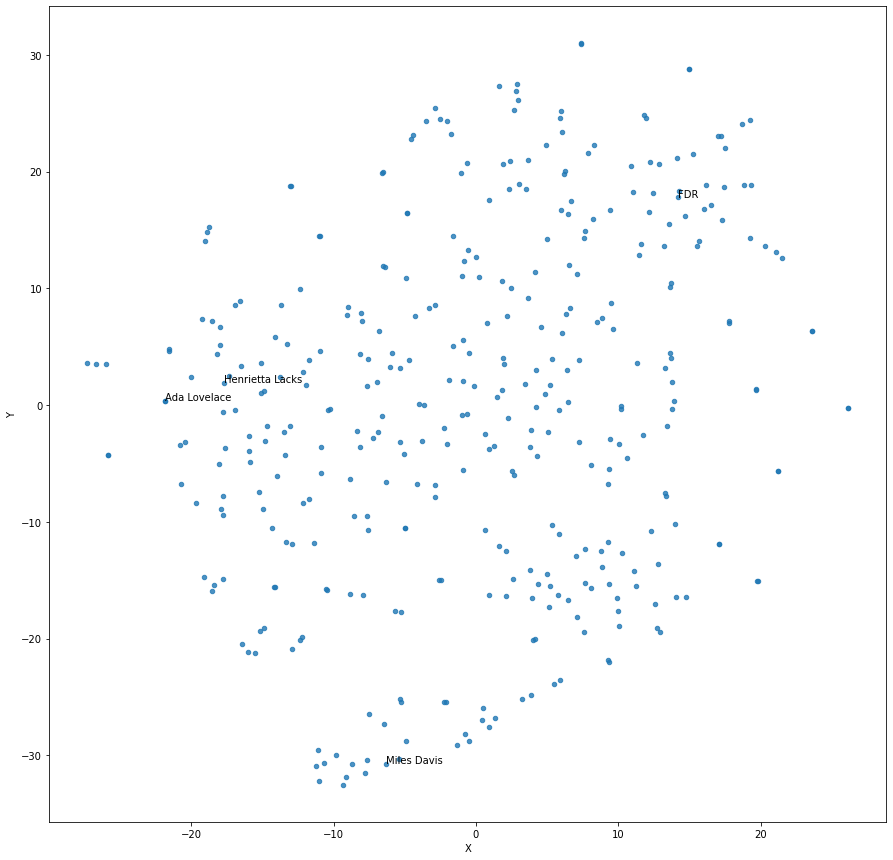

In [55]:
ax = vis_data.plot.scatter(figsize = (15, 15), x = 'X', y = 'Y', alpha = 0.8);
vis_data[vis_data['NAME'].isin(people)][['X', 'Y', 'NAME']].apply(lambda x: ax.text(*x), axis = 1);

```{margin} A caveat
It's important to remember that the transformation between high dimensional space and this 2D plot is a lossy one. 
Distortions will result from it, and having a good sense of what kind of distortions you might expect to see with 
t-SNE will help you interpret these graphs. This [interactive dashboard] offers a really nice overview of these 
considerations.

[interactive dashboard]: https://distill.pub/2016/misread-tsne/
```

As with our toy example above, here, space has semantic value. Points that appear closer together in the 
visualization above have more similarities between them than those that are farther apart. We can see this clearly 
if we show a person's point and the most similar point to that person.

In [ ]:
roosevelts = ['FDR', 'Eleanor Roosevelt']

ax = vis_data.plot.scatter(figsize = (15, 15), x = 'X', y = 'Y', alpha = 0.8);
vis_data[vis_data['NAME'].isin(roosevelts)][['X', 'Y', 'NAME']].apply(lambda x: ax.text(*x), axis = 1);

Quite close!

Clustering by Similarity
---------------------------

The last topic we'll cover in this chapter involves dividing up the feature space of our data so as to broadly 
cluster the texts in our corpus. This will give us a frame for considering general trends in the data, which in 
turn may better help us understand the specificity of individual texts. For example, clustering might allow us to 
speak about various subgenres of obituaries. Similarly, it could tell us something about how the _New York Times_ 
writes about particular kinds of people (their vocations, their backgrounds, etc.). It may even indicate something 
about how the style of the obituary has changed over time.

But how to do it? Visual inspection of the graphs above would be one way. There are a few discernible clusters in 
it. Consider the division in points that cuts up toward the right from the bottom center of the graph; there's a 
particularly dense patch of points near the Roosevelts' position as well. But while could slice and dice these 
points using visual cues for ages, these cues can sometimes be misleading. It would be better, then, to use 
unsupervised methods to automatically partition our feature space.

There are a host of different such techniques available. Below, we'll use **hierarchical clustering**. In 
hierarchical clustering, each data point is treated as an individual cluster before being successfully merged with 
its most similar point. Then, this new cluster is merged with another cluster, and the process repeats. Merging 
continues in an upward fashion until the process reaches a predetermined number of clusters.

We can't go into detail about how to determine the best number of clusters for a dataset. It's a complex topic, and 
much depends on a) your data; and b) what you want to know about your data. For now, we'll stick with a general, 
rather rudimentary approach, which you can nuance later on.

Once again, `scikit-learn` has functionality for clustering. We just need to initialize and fit an 
`AgglomerativeClustering()` object to our similarities, defining along the way the number of clusters we'd like to 
generate.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 3
agg = AgglomerativeClustering(n_clusters = n_clusters).fit(similarities)

The result will be a fitted `AgglomerativeClustering()` object, which works much like `CountVectorizer()` or 
`TfidfVectorizer()` in the last chapter. We can access its `labels_` attribute and assign a cluster label to each 
point in our data. We'll also use this attribute to add some color to our visualization, which will make it easier 
to discern the clusters.

In [ ]:
vis_data = vis_data.assign(CLUSTER = agg.labels_ + 1)
vis_data = vis_data.assign(COLOR = vis_data['CLUSTER'].replace({1: 'red', 2: 'blue', 3: 'green'}))

And now we can visualize. We'll sample a few names and show those as well.

In [ ]:
ax = vis_data.plot.scatter(figsize = (15, 15), x = 'X', y = 'Y', c = 'COLOR', alpha = 0.8)
vis_data[['X', 'Y', 'NAME']].sample(10).apply(lambda x: ax.text(*x), axis = 1);

Not bad at all! There are a few incursions of one cluster into another, but for the most part this looks pretty 
coherent (it may even be that those incursions are exaggerated by the visualization, as the note above explains). 
Let's grab some examples of each cluster and show them.

```{margin} What this loop does
1. Group the data by `CLUSTER`
2. For each group, sample `n_samples`
3. Print each name in the sampled results
```

In [ ]:
n_samples = 5
for tup in vis_data.groupby('CLUSTER'):
    cluster = tup[0]
    subset = tup[1]
    print(f"Cluster: {cluster}\n----------")
    sampled = subset.sample(n_samples)['NAME']
    for name in sampled:
        print(name)
    print("\n")

Looking over these results turns up an interesting pattern: one way to interpret these clusters is by profession. 
The people in the first cluster tend to be entertainers, usually popular ones working in/with popular media forms; 
Billie Holiday and Marilyn Monroe are in this cluster, for example. Those in the second one, on the other hand, 
tend to be political figures: Ghandi, Adlai Stevenson, and so on. Finally, those in cluster three are often 
novelists, activists, and other kinds of public figures; Helen Keller is in this cluster, along with Joseph 
Pulitzer and Jackie Robinson. From an initial glance, then, our text similarity data seems to suggest that _a 
person's profession indicates something about the type of obituary they have_.

Of course, there are intriguing exceptions. Eugene O'Neill, a playwright, is in the second cluster, whereas the 
division we've just suggested would put him in the third cluster, alongside Sylvia Plath and James Joyce. The Duke 
of Windsor (Edward VIII) is an interesting test case: he is a political figure, though he quickly abdicated from 
the throne. Should he therefore be in the second cluster or, as he is here, in the third cluster?

In [ ]:
unexpected = ['Eugene O Neill', 'The Duke of Windsor']
vis_data[vis_data['NAME'].isin(unexpected)][['NAME', 'CLUSTER', 'COLOR']].style.hide_index()

The question for both exceptions is why. What is it about these two people – or more specifically, their obituaries 
– that pushes them outside the cluster we'd expect them to be in? Is it a particular set of words? Lexical 
diversity? Something else?

Investigating these questions will take us beyond the scope of this chapter. For now, it's enough to know that text 
similarity prompts them and that we can explore and analyze corpora using this metric. We'll end, then, with this 
preliminary hypothesis about our clusters, which later work will need to either corroborate or challenge.